In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory      
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv
/kaggle/input/fakenews-poland-clean-topics/topics.csv
/kaggle/input/fakenews-poland-clean-topics/fake_news_features_combined.csv


In [2]:
!pip install sentence-transformers
!pip install transformers
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 943.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=bb055edf2925eee584793f5e40a69cd07ea92d0fbfbcd4851e1be48be949ffe5
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [12]:
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.base import clone as sklearn_clone

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    recall_score,
    precision_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, HerbertTokenizer, BatchEncoding

import gc

In [4]:
torch.manual_seed(111)
np.random.seed(111)
random.seed(111)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()
    
device.type

'cuda'

## Get HerBERT

In [5]:
# tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-large-cased")
model_herbert = AutoModel.from_pretrained("allegro/herbert-large-cased")

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

Some weights of the model checkpoint at allegro/herbert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Get data

In [6]:
df_topics = pd.read_csv('../input/fakenews-poland-clean-topics/topics.csv', index_col=0)

In [7]:
df = pd.read_csv('../input/fakenews-poland-clean-topics/fake_news_features_combined.csv', sep=';')

df = df[ df['assestment'] != 'brak' ]

df.loc[:, 'assestment'] = df['assestment'].replace({
    'falsz' : 'Fałsz',
    'zbity_zegar' : 'Fałsz',
    'raczej_falsz' : 'Fałsz',
    'prawda' : 'Prawda',
    'blisko_prawdy' : 'Prawda',
    'polprawda' : 'Manipulacja',
    'Częściowy fałsz' : 'Manipulacja'
})

df = df[ df['assestment'] != 'Nieweryfikowalne' ]
df = df[ df['assestment'] != 'Manipulacja' ]

df['assestment'] = df['assestment'].replace({
    'Fałsz' : 0,
#     'Manipulacja' : 1,
    'Prawda' : 1
}).astype(int)

df = df.copy()[['assestment', 'text_clean']][df.index.isin(df_topics.index)].reset_index(drop=True)

In [8]:
embeddings_table = pd.read_csv('../input/fakenews-poland-clean-topics/embeddings_pl_herbert.csv', sep=",", header=None).values

In [9]:
class FakeNews(Dataset):
    def __init__(self, emb_dt, y_dt, index_to_use):
        self.emb = emb_dt[index_to_use]
        
        self.labels = y_dt[index_to_use]
        
        self.index = np.arange(index_to_use.shape[0])
        
    def __len__(self):
        return len(self.emb)
    
    def __getitem__(self, item):
        anchor_label = self.labels[item]

        positive_list = self.index[self.index!=item][self.labels[self.index!=item]==anchor_label]

        positive_item = random.choice(positive_list)
        
        negative_list = self.index[self.index!=item][self.labels[self.index!=item]!=anchor_label]
        negative_item = random.choice(negative_list)
        
        anchor_claim = self.emb[item].astype(np.float32)
        positive_claim = self.emb[positive_item].astype(np.float32)
        negative_claim = self.emb[negative_item].astype(np.float32)

        anchor_label = anchor_label.astype(np.float32)

        return anchor_claim, positive_claim, negative_claim, anchor_label

## Kfold

In [16]:
cv_fold = []
cv_fold_i = []

for i in df_topics['topic'].unique().reshape(10,-1):
    train_cv = df_topics.index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv = df_topics.index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv = df_topics.index[ np.isin(df_topics["topic"], i) ].values
    
    train_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], [i, np.mod(i+1,10)]) ].values
    val_cv_i = df_topics.reset_index().index[ ~np.isin(df_topics["topic"], np.mod(i+1,10)) ].values
    test_cv_i = df_topics.reset_index().index[ np.isin(df_topics["topic"], i) ].values
    
    cv_fold.append( [train_cv, val_cv, test_cv])
    cv_fold_i.append( [train_cv_i, val_cv_i, test_cv_i])

In [17]:
kf = KFold(n_splits=10, shuffle=True)
kf.get_n_splits(df_topics)

cv_Kfold = []
cv_Kfold_i = []

for train_index, test_index in kf.split(df_topics):
    train_index, val_index = train_test_split(train_index, test_size=1/9, shuffle=True)
    train_cv = df_topics.iloc[ train_index, : ].index.values
    val_cv = df_topics.iloc[ val_index, : ].index.values
    test_cv = df_topics.iloc[ test_index, : ].index.values

    train_cv_i= df_topics.reset_index().iloc[ train_index, : ].index.values
    val_cv_i = df_topics.reset_index().iloc[ val_index, : ].index.values
    test_cv_i = df_topics.reset_index().iloc[ test_index, : ].index.values
    
    cv_Kfold.append( [train_cv, val_cv, test_cv])
    cv_Kfold_i.append( [train_cv_i, val_cv_i, test_cv_i])

## Train

## TripletLoss

In [19]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

## Define Net

In [20]:
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        
        self.fc = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.ReLU(),
#             nn.Dropout(0.2),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
#             nn.Linear(512, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, emb_dim)
        )
        
    def forward(self, x):
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

## Some testing one one kfold

In [85]:
embedding_dims = 128
batch_size = 128
epochs = 1000

In [86]:
train_index, val_index, test_index = cv_fold_i[0]

In [87]:
train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

In [88]:
model = Network(embedding_dims)
# model = torch.nn.DataParallel(model)
# model = torch.jit.script(model).to(device)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = torch.jit.script(TripletLoss())
criterion = TripletLoss()

## Training loop

In [89]:
train_loss_out = []
val_loss_out = []

val_prev = np.inf

model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
        anchor_claim = (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = (negative_claim / torch.norm(negative_claim) ).to(device)

        optimizer.zero_grad()
        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
        
    
    model.eval()
    
    val_loss = []
    for anchor_claim, positive_claim, negative_claim, _ in val_loader:
        anchor_claim = (anchor_claim / torch.norm(anchor_claim) ).to(device)
        positive_claim = (positive_claim / torch.norm(positive_claim) ).to(device)
        negative_claim = (negative_claim / torch.norm(negative_claim) ).to(device)

        anchor_out = model(anchor_claim)
        positive_out = model(positive_claim)
        negative_out = model(negative_claim)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        val_loss.append(loss.cpu().detach().numpy())
    
    model.train()
    
    train_loss_out.append(np.mean(running_loss))
    val_loss_out.append(np.mean(val_loss))
    
    if np.mean(val_loss) < val_prev:
        print(epoch, f'saved {np.mean(val_loss):.4f} < {val_prev:.4f}')
        val_prev = np.mean(val_loss)
        torch.save(model, 'model_0_001.pt')
        
    if epoch%10 == 0:
        print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
              f" Val Loss: {np.mean(val_loss):.4f}")


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

0 saved 1.5533 < inf
0 Epoch: 1/1000 - Train Loss: 6.1450;  Val Loss: 1.5533
1 saved 1.2372 < 1.5533
2 saved 1.1580 < 1.2372
3 saved 1.0378 < 1.1580
5 saved 0.9973 < 1.0378
6 saved 0.9965 < 0.9973
7 saved 0.9954 < 0.9965
8 saved 0.9922 < 0.9954
10 saved 0.9903 < 0.9922
0 Epoch: 11/1000 - Train Loss: 1.2058;  Val Loss: 0.9903
20 saved 0.9894 < 0.9903
0 Epoch: 21/1000 - Train Loss: 1.0031;  Val Loss: 0.9894
21 saved 0.9837 < 0.9894
23 saved 0.9818 < 0.9837
24 saved 0.9786 < 0.9818
25 saved 0.9757 < 0.9786
26 saved 0.9743 < 0.9757
28 saved 0.9663 < 0.9743
0 Epoch: 31/1000 - Train Loss: 0.9708;  Val Loss: 0.9690
31 saved 0.9637 < 0.9663
32 saved 0.9570 < 0.9637
33 saved 0.9550 < 0.9570
34 saved 0.9411 < 0.9550
37 saved 0.9241 < 0.9411
39 saved 0.9150 < 0.9241
0 Epoch: 41/1000 - Train Loss: 0.9001;  Val Loss: 0.9413
41 saved 0.9140 < 0.9150
42 saved 0.9139 < 0.9140
43 saved 0.8992 < 0.9139
47 saved 0.8888 < 0.8992
0 Epoch: 51/1000 - Train Loss: 0.7577;  Val Loss: 0.9434
58 saved 0.8727 < 0.

In [72]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for claim, _, _, label in tqdm(train_loader):
        anchor_claim = claim.to(device)
        
        train_results.append(model(anchor_claim).cpu().numpy())
        labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

train_results = np.concatenate(train_results) 
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(5270, 128)

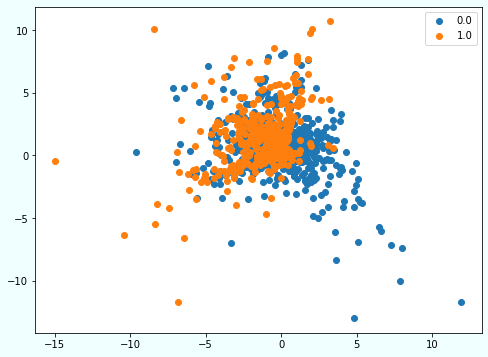

In [73]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [74]:
test_results = []
test_labels = []

model.eval()
with torch.no_grad():
    for claim, _, _, label in tqdm(train_loader):
        anchor_claim = claim.to(device)
        
        test_results.append(model(anchor_claim).cpu().numpy())
        test_labels.append(label)
        
#         del anchor_claim 
#         gc.collect()
#         torch.cuda.empty_cache()

test_results = np.concatenate(test_results)
test_labels = np.concatenate(test_labels)
test_results.shape

  0%|          | 0/42 [00:00<?, ?it/s]

(5270, 128)

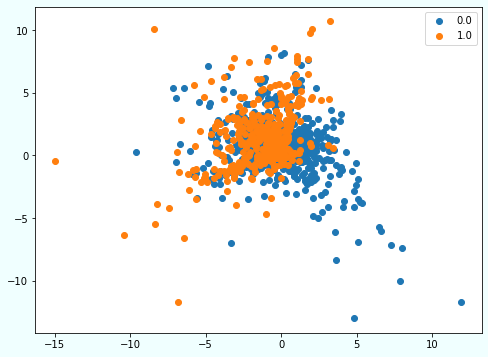

In [75]:
plt.figure(figsize=(8, 6), facecolor="azure")
for label in np.unique(test_labels):
    tmp = test_results[test_labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)

plt.legend()
plt.show()

In [76]:
clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

In [77]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


y_train_t = labels
X_train_t = train_results
y_test_t = test_labels
X_test_t = test_results

clf_lr_1.fit(X_train_t, y_train_t)

y_pred = clf_lr_1.predict(X_test_t)

results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
results['test_f1'].append( f1_score(y_test_t, y_pred) ) 

metrics = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

In [81]:
confusion_matrix(y_test_t, y_pred)

array([[1197, 1559],
       [ 160, 2354]])

In [78]:
metrics

{'Accuracy': array([0.67381404]), 'F1 Score': array([0.73253462])}

# Test using CV

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 500
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

Epochs 0:   0%|          | 0/1000 [00:00<?, ?it/s]

0 Epoch: 1/1000 - Train Loss: 5.3953;  Val Loss: 1.5809 Val loss best 1.5809
0 Epoch: 101/1000 - Train Loss: 0.3121;  Val Loss: 0.2545 Val loss best 0.2500
0 Epoch: 201/1000 - Train Loss: 0.0900;  Val Loss: 0.1797 Val loss best 0.1569
0 Epoch: 301/1000 - Train Loss: 0.0616;  Val Loss: 0.1770 Val loss best 0.1559
0 Epoch: 401/1000 - Train Loss: 0.0517;  Val Loss: 0.1785 Val loss best 0.1559
0 Epoch: 501/1000 - Train Loss: 0.0316;  Val Loss: 0.2004 Val loss best 0.1553
0 Epoch: 601/1000 - Train Loss: 0.0272;  Val Loss: 0.2018 Val loss best 0.1553
0 Epoch: 701/1000 - Train Loss: 0.0312;  Val Loss: 0.1836 Val loss best 0.1553
0 Epoch: 801/1000 - Train Loss: 0.0329;  Val Loss: 0.1713 Val loss best 0.1553
0 Epoch: 901/1000 - Train Loss: 0.0187;  Val Loss: 0.1868 Val loss best 0.1553


Epochs 1:   0%|          | 0/1000 [00:00<?, ?it/s]

1 Epoch: 1/1000 - Train Loss: 5.3432;  Val Loss: 1.2841 Val loss best 1.2841
1 Epoch: 101/1000 - Train Loss: 0.3023;  Val Loss: 0.2756 Val loss best 0.2727
1 Epoch: 201/1000 - Train Loss: 0.0987;  Val Loss: 0.2393 Val loss best 0.2102
1 Epoch: 301/1000 - Train Loss: 0.0675;  Val Loss: 0.2212 Val loss best 0.2102
1 Epoch: 401/1000 - Train Loss: 0.0312;  Val Loss: 0.2725 Val loss best 0.2102
1 Epoch: 501/1000 - Train Loss: 0.0369;  Val Loss: 0.2500 Val loss best 0.2102
1 Epoch: 601/1000 - Train Loss: 0.0237;  Val Loss: 0.2525 Val loss best 0.2102
1 Epoch: 701/1000 - Train Loss: 0.0270;  Val Loss: 0.2628 Val loss best 0.2102
1 Epoch: 801/1000 - Train Loss: 0.0219;  Val Loss: 0.2662 Val loss best 0.2102
1 Epoch: 901/1000 - Train Loss: 0.0229;  Val Loss: 0.2825 Val loss best 0.2102


Epochs 2:   0%|          | 0/1000 [00:00<?, ?it/s]

2 Epoch: 1/1000 - Train Loss: 5.5180;  Val Loss: 1.4256 Val loss best 1.4256
2 Epoch: 101/1000 - Train Loss: 0.5640;  Val Loss: 0.4180 Val loss best 0.3884
2 Epoch: 201/1000 - Train Loss: 0.1523;  Val Loss: 0.2043 Val loss best 0.1800
2 Epoch: 301/1000 - Train Loss: 0.1713;  Val Loss: 0.1975 Val loss best 0.1743
2 Epoch: 401/1000 - Train Loss: 0.0619;  Val Loss: 0.2017 Val loss best 0.1743
2 Epoch: 501/1000 - Train Loss: 0.0731;  Val Loss: 0.1877 Val loss best 0.1743
2 Epoch: 601/1000 - Train Loss: 0.0600;  Val Loss: 0.2083 Val loss best 0.1743
2 Epoch: 701/1000 - Train Loss: 0.0602;  Val Loss: 0.2017 Val loss best 0.1743
2 Epoch: 801/1000 - Train Loss: 0.0492;  Val Loss: 0.2053 Val loss best 0.1743
2 Epoch: 901/1000 - Train Loss: 0.0367;  Val Loss: 0.2262 Val loss best 0.1743


Epochs 3:   0%|          | 0/1000 [00:00<?, ?it/s]

3 Epoch: 1/1000 - Train Loss: 5.5525;  Val Loss: 1.3904 Val loss best 1.3904
3 Epoch: 101/1000 - Train Loss: 0.2920;  Val Loss: 0.2203 Val loss best 0.2155
3 Epoch: 201/1000 - Train Loss: 0.0869;  Val Loss: 0.1734 Val loss best 0.1465
3 Epoch: 301/1000 - Train Loss: 0.0547;  Val Loss: 0.1673 Val loss best 0.1408
3 Epoch: 401/1000 - Train Loss: 0.0356;  Val Loss: 0.1710 Val loss best 0.1408
3 Epoch: 501/1000 - Train Loss: 0.0279;  Val Loss: 0.1808 Val loss best 0.1408
3 Epoch: 601/1000 - Train Loss: 0.0213;  Val Loss: 0.1926 Val loss best 0.1408
3 Epoch: 701/1000 - Train Loss: 0.0184;  Val Loss: 0.1691 Val loss best 0.1408
3 Epoch: 801/1000 - Train Loss: 0.0207;  Val Loss: 0.1681 Val loss best 0.1408
3 Epoch: 901/1000 - Train Loss: 0.0182;  Val Loss: 0.1790 Val loss best 0.1408


Epochs 4:   0%|          | 0/1000 [00:00<?, ?it/s]

4 Epoch: 1/1000 - Train Loss: 5.5864;  Val Loss: 1.4618 Val loss best 1.4618
4 Epoch: 101/1000 - Train Loss: 0.2885;  Val Loss: 0.2313 Val loss best 0.2216
4 Epoch: 201/1000 - Train Loss: 0.0891;  Val Loss: 0.1730 Val loss best 0.1463
4 Epoch: 301/1000 - Train Loss: 0.0617;  Val Loss: 0.1769 Val loss best 0.1463
4 Epoch: 401/1000 - Train Loss: 0.0343;  Val Loss: 0.1558 Val loss best 0.1463
4 Epoch: 501/1000 - Train Loss: 0.0257;  Val Loss: 0.1740 Val loss best 0.1463
4 Epoch: 601/1000 - Train Loss: 0.0251;  Val Loss: 0.1891 Val loss best 0.1463
4 Epoch: 701/1000 - Train Loss: 0.0181;  Val Loss: 0.1792 Val loss best 0.1463
4 Epoch: 801/1000 - Train Loss: 0.0183;  Val Loss: 0.1784 Val loss best 0.1463
4 Epoch: 901/1000 - Train Loss: 0.0184;  Val Loss: 0.1662 Val loss best 0.1463


Epochs 5:   0%|          | 0/1000 [00:00<?, ?it/s]

5 Epoch: 1/1000 - Train Loss: 5.4133;  Val Loss: 1.4566 Val loss best 1.4566
5 Epoch: 101/1000 - Train Loss: 0.3202;  Val Loss: 0.2397 Val loss best 0.2386
5 Epoch: 201/1000 - Train Loss: 0.0870;  Val Loss: 0.1883 Val loss best 0.1733
5 Epoch: 301/1000 - Train Loss: 0.0559;  Val Loss: 0.2129 Val loss best 0.1570
5 Epoch: 401/1000 - Train Loss: 0.0436;  Val Loss: 0.1941 Val loss best 0.1570
5 Epoch: 501/1000 - Train Loss: 0.0245;  Val Loss: 0.1900 Val loss best 0.1570
5 Epoch: 601/1000 - Train Loss: 0.0253;  Val Loss: 0.1974 Val loss best 0.1570
5 Epoch: 701/1000 - Train Loss: 0.0184;  Val Loss: 0.2275 Val loss best 0.1570
5 Epoch: 801/1000 - Train Loss: 0.0121;  Val Loss: 0.2107 Val loss best 0.1570
5 Epoch: 901/1000 - Train Loss: 0.0135;  Val Loss: 0.2123 Val loss best 0.1570


Epochs 6:   0%|          | 0/1000 [00:00<?, ?it/s]

6 Epoch: 1/1000 - Train Loss: 5.4043;  Val Loss: 1.3594 Val loss best 1.3594
6 Epoch: 101/1000 - Train Loss: 0.2897;  Val Loss: 0.2265 Val loss best 0.2148
6 Epoch: 201/1000 - Train Loss: 0.0863;  Val Loss: 0.1589 Val loss best 0.1436
6 Epoch: 301/1000 - Train Loss: 0.0488;  Val Loss: 0.1709 Val loss best 0.1435
6 Epoch: 401/1000 - Train Loss: 0.0372;  Val Loss: 0.1969 Val loss best 0.1435
6 Epoch: 501/1000 - Train Loss: 0.0290;  Val Loss: 0.1718 Val loss best 0.1435
6 Epoch: 601/1000 - Train Loss: 0.0257;  Val Loss: 0.1684 Val loss best 0.1435
6 Epoch: 701/1000 - Train Loss: 0.0226;  Val Loss: 0.1727 Val loss best 0.1435
6 Epoch: 801/1000 - Train Loss: 0.0177;  Val Loss: 0.1695 Val loss best 0.1435
6 Epoch: 901/1000 - Train Loss: 0.0175;  Val Loss: 0.1632 Val loss best 0.1435


Epochs 7:   0%|          | 0/1000 [00:00<?, ?it/s]

7 Epoch: 1/1000 - Train Loss: 5.3916;  Val Loss: 1.4020 Val loss best 1.4020
7 Epoch: 101/1000 - Train Loss: 0.3424;  Val Loss: 0.2224 Val loss best 0.2224
7 Epoch: 201/1000 - Train Loss: 0.0908;  Val Loss: 0.1562 Val loss best 0.1342
7 Epoch: 301/1000 - Train Loss: 0.0694;  Val Loss: 0.1417 Val loss best 0.1271


### Get use best models

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}


for j, (train_index, val_index, test_index) in enumerate(cv_fold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = torch.load(f'model_cv{j}.pt')
    model = model.to(device)

    model.eval()
   
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    

In [ ]:
results = {
    'test_accuracy' : [],
    'test_precision' : [],
    'test_recall' : [],
    'test_f1' : []
}

embedding_dims = 100
batch_size = 128
epochs = 1000
lr = 0.001

for j, (train_index, val_index, test_index) in enumerate(cv_Kfold_i):
    train_ds = FakeNews(embeddings_table, df['assestment'].values, train_index)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    
    val_ds = FakeNews(embeddings_table, df['assestment'].values, val_index)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2)

    test_ds = FakeNews(embeddings_table, df['assestment'].values, test_index)
    test_loader = DataLoader(test_ds, batch_size=batch_size//2, shuffle=False, num_workers=2)

    
    model = Network(embedding_dims)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = TripletLoss()

    val_prev = np.inf
    
    model.train()
    for epoch in tqdm(range(epochs), desc=f"Epochs {j}"):
        running_loss = []
        for step, (anchor_claim, positive_claim, negative_claim, anchor_label) in enumerate(train_loader):
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            optimizer.zero_grad()
            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            loss.backward()
            optimizer.step()

            running_loss.append(loss.cpu().detach().numpy())

        model.eval()
    
        val_loss = []
        for anchor_claim, positive_claim, negative_claim, _ in val_loader:
            anchor_claim = anchor_claim.to(device)
            positive_claim = positive_claim.to(device)
            negative_claim = negative_claim.to(device)

            anchor_out = model(anchor_claim)
            positive_out = model(positive_claim)
            negative_out = model(negative_claim)

            loss = criterion(anchor_out, positive_out, negative_out)
            val_loss.append(loss.cpu().detach().numpy())

        model.train()
        
        if np.mean(val_loss) < val_prev:
            val_prev = np.mean(val_loss)
            torch.save(model, f'model_cv{j}.pt')
        
        if epoch%100 == 0:
            print(f"{j} Epoch: {epoch+1}/{epochs} - Train Loss: {np.mean(running_loss):.4f};",
                  f" Val Loss: {np.mean(val_loss):.4f} Val loss best {val_prev:.4f}"
             )
            
    
    train_results = []
    labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in train_loader:
            anchor_claim = claim.to(device)

            train_results.append(model(anchor_claim).cpu().numpy())
            labels.append(label)


    train_results = np.concatenate(train_results) 
    labels = np.concatenate(labels)

    
    test_results = []
    test_labels = []

    model.eval()
    with torch.no_grad():
        for claim, _, _, label in test_loader:
            anchor_claim = claim.to(device)

            test_results.append(model(anchor_claim).cpu().numpy())
            test_labels.append(label)


    test_results = np.concatenate(test_results)
    test_labels = np.concatenate(test_labels)

    
    clf_lr_1 = LogisticRegression(max_iter=5000, C=1, penalty='l2', solver='liblinear')

    y_train_t = labels
    X_train_t = train_results
    y_test_t = test_labels
    X_test_t = test_results

    clf_lr_1.fit(X_train_t, y_train_t)

    y_pred = clf_lr_1.predict(X_test_t)

    results['test_accuracy'].append( accuracy_score(y_test_t, y_pred) ) 
    results['test_precision'].append( precision_score(y_test_t, y_pred) ) 
    results['test_recall'].append( recall_score(y_test_t, y_pred) ) 
    results['test_f1'].append( f1_score(y_test_t, y_pred) ) 


out = {
    "Accuracy": np.array(results['test_accuracy']),
#     "Precision": np.array(results['test_precision']).mean(),
#     "Recall": np.array(results['test_recall']).mean(),
    "F1 Score":  np.array(results['test_f1']),
    }

print(
    'triplet loss lr C1',
    f'Accuracy {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f}',
    f'F1 Score {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}',
    f' {out["Accuracy"].mean():.3f}+-{out["Accuracy"].std():.3f} | {out["F1 Score"].mean():.3f}+-{out["F1 Score"].std():.3f}'
)    